In [1]:
# imports
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import utils
import time
from torch.utils.benchmark import Timer
import json
from torch.utils.data import DataLoader
import os
import h5py
import math
import scienceplots

In [2]:
plt.style.use(["science", "notebook", "grid"])

### Technical Stuff (Engineering)

In [21]:
import sys

# Set the cache size limit to the largest possible integer
torch._dynamo.config.cache_size_limit = sys.maxsize

print(f"torch._dynamo.config.cache_size_limit is now set to: {torch._dynamo.config.cache_size_limit}")

torch._dynamo.config.cache_size_limit is now set to: 9223372036854775807


In [22]:
torch.set_float32_matmul_precision('highest')

In [23]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

Using device: cuda



### Running training script

In [ ]:
# for diag_line in [0, 1]:
#     TRAIN_DATASET1 = f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/hubbard_model_lowest_energy_8x8_diagonal_{diag_line}_fixed.h5"
#     TRAIN_DATASET2 = f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/hubbard_model_lowest_energy_10x10_diagonal_{diag_line}_fixed.h5"

#     filenames_dict = {
#         TRAIN_DATASET1: 548,
#         TRAIN_DATASET2: 1029,
#     }

#     # get normalization constants
#     x_mean, x_std, y_mean, y_std = utils.get_normalization_constants_3x3(filenames_dict, write_to=f"normalization_constants_{diag_line}.json")

#     print("Normalization Constants:")
#     print(f"\nInputs Mean: {x_mean}, Inputs Standard Deviation: {x_std}")
#     print(f"Targets Mean: {y_mean}, Targets Standard Deviation: {y_std}")

Normalization Constants:

Inputs Mean: 1.0006963014602661, Inputs Standard Deviation: 0.500472903251648
Targets Mean: 0.25, Targets Standard Deviation: 0.39119455218315125
Normalization Constants:

Inputs Mean: 0.9969735741615295, Inputs Standard Deviation: 0.4087181091308594
Targets Mean: -6.189513896970311e-07, Targets Standard Deviation: 0.18565334379673004


In [34]:
# set batch size

# for lr scheduler
MAX_LR = 1e-3
MAX_NUM_EPOCHS = 5_000
NUM_WARMUP_EPOCHS = 20


def training_script(num_freqs: int, index: int = 0):

    # number of frequencies
    NUM_FREQS = num_freqs

    # make a new folder for this test
    folder_name = f"/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/{NUM_FREQS}_test_index_{index}_fixed_combined"

    # Check if CUDA is available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    dims = list(range(8, 19, 2))    # should go from 8 to 18 in increments of 2
    filenames = [f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/diagonal_coords_{d}x{d}.pt" for d in dims]

    model = utils.HF_SimpleModel(
        filenames,
        num_layers = 3,
        input_dim = 8,
        embed_dim = 64,
        output_dim = 8,
        num_heads = 4,
        num_freqs = NUM_FREQS,
        dim_feedforward = 128,
        input_dropout = 0.1,
        output_dropout = 0.0,
        dropout = 0.1,
        device = device
    )

    try:
        os.mkdir(folder_name)
        print(f"Folder '{folder_name}' created successfully.\n")
    except FileExistsError:
        print(f"Folder '{folder_name}' already exists.\n")

        # Load the saved state_dict
        print(f"Loading model from {folder_name}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_final_fixed_combined.pth")
        state_dict = torch.load(f"{folder_name}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_final_fixed_combined.pth")

        # Create a new state_dict without the prefix
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('_orig_mod.'):
                name = k[10:] # remove `_orig_mod.`
                new_state_dict[name] = v
            else:
                new_state_dict[k] = v

        # Load the corrected state_dict
        model.load_state_dict(new_state_dict)
        
    except OSError as e:
        print(f"Error creating folder: {e}\n")
    
    # compile the model
    model = torch.compile(model, mode="max-autotune", fullgraph=True)
    

    TRAIN_DATASET1 = f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/hubbard_model_lowest_energy_8x8_fixed_combined.h5"
    TRAIN_DATASET2 = f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/hubbard_model_lowest_energy_10x10_fixed_combined.h5"
    VAL_DATASET = f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/hubbard_model_lowest_energy_18x18_fixed_combined.h5"

    filenames_dict = {
        TRAIN_DATASET1: 548,
        TRAIN_DATASET2: 1029,
    }

    # get normalization constants
    x_mean, x_std, y_mean, y_std = utils.get_normalization_constants_3x3(filenames_dict, write_to=f"normalization_constants_combined.json")

    print("Normalization Constants:")
    print(f"\nInputs Mean: {x_mean}, Inputs Standard Deviation: {x_std}")
    print(f"Targets Mean: {y_mean}, Targets Standard Deviation: {y_std}")

    # get norm constants dict
    with open(f"normalization_constants_combined.json", "r") as f:
        normalization_constants = json.load(f)

    # make training and validation datasets
    training_data1 = utils.HF_3x3_Dataset(TRAIN_DATASET1, normalization_constants)
    print(f"Training dataset length: {training_data1.__len__()}\n")

    training_data2 = utils.HF_3x3_Dataset(TRAIN_DATASET2, normalization_constants)
    print(f"Training dataset length: {training_data2.__len__()}\n")

    validation_data = utils.HF_3x3_Dataset(VAL_DATASET, normalization_constants)
    print(f"Test dataset length: {validation_data.__len__()}\n")

    # training and test dataloaders
    train_dataloader1 = DataLoader(training_data1, 50, shuffle=True, pin_memory=True, num_workers=1)
    train_dataloader2 = DataLoader(training_data2, 100, shuffle=True, pin_memory=True, num_workers=1)
    val_dataloader = DataLoader(validation_data, 50, shuffle=True, pin_memory=True, num_workers=1)

    # Loss function and optimizer
    loss_fn = torch.nn.MSELoss(reduction = "sum")
    optimizer = torch.optim.AdamW(model.parameters(), lr=MAX_LR)

    # Define schedulers
    min_lr = 1e-7
    k = min_lr / MAX_LR
    linear_warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=k, end_factor=1.0, total_iters=NUM_WARMUP_EPOCHS)

    cosine_annealing = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = (MAX_NUM_EPOCHS - NUM_WARMUP_EPOCHS))

    # Combine them
    scheduler = torch.optim.lr_scheduler.SequentialLR(
        optimizer,
        schedulers=[linear_warmup, cosine_annealing],
        milestones=[NUM_WARMUP_EPOCHS]
    )


    train_losses = []
    val_losses = []

    # train the model and record the loss for the training and validation datasets
    for t in range(MAX_NUM_EPOCHS):
        print(f"Epoch {t + 1}\n-------------------------------")
        train_losses.append(
            utils.train_loop([train_dataloader1, train_dataloader2], model, loss_fn, optimizer, scheduler, device)
        )
        val_losses.append(utils.test_loop([val_dataloader], model, loss_fn, device))
        # save the model occasionally
        if (t % 100 == 0):
            print("Saving model...")
            torch.save(
                model.state_dict(),
                f"{folder_name}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_epoch_{t + 1}_fixed_combined.pth",
            )
            print("Model saved!\n")
    print("Done!\n")

    print(f"Training Losses (1-{MAX_NUM_EPOCHS}): {train_losses}")
    print(f"Test Losses (1-{MAX_NUM_EPOCHS}): {val_losses}\n")

    utils.plot_losses(train_losses, val_losses, img_filename=f"{folder_name}/train_test_losses.png")

    # saving model
    torch.save(
        model.state_dict(),
        f"{folder_name}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_final_fixed_combined.pth",
    )

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_0_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817


Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------


/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:236: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W0816 05:54:00.427000 3244369 torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode
AUTOTUNE addmm(3200x8, 3200x64, 64x8)
  bias_addmm 0.0154 ms 100.0% 
  addmm 0.0184 ms 83.3% 
SingleProcess AUTOTUNE benchmarking takes 5.6272 seconds and 0.0001 seconds precompiling for 2 choices
AUTOTUNE addmm(10000x8, 10000x64, 64x8)
  bias_addmm 0.0205 ms 100.0% 
  addmm 0.0225 ms 90.9% 
SingleProcess AUTOTUNE benchmarking takes 0.0843 seconds and 0.0001 seconds precompiling for 2 choices
AUTOTUNE addmm(3072x8, 3072x64, 64x8)
  bias_addmm 0.0192 ms 100.0% 
  addmm 0.0205 ms 93.9% 
SingleProcess AUTOTUNE benchmarking takes 0.0840 seconds and 0.0001 seconds prec

Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.005199


AUTOTUNE addmm(9072x64, 9072x8, 8x64)
  addmm 0.0195 ms 100.0% 
  bias_addmm 0.0276 ms 70.4% 
SingleProcess AUTOTUNE benchmarking takes 0.0862 seconds and 0.0001 seconds precompiling for 2 choices
AUTOTUNE addmm(9072x8, 9072x64, 64x8)
  bias_addmm 0.0244 ms 100.0% 
  addmm 0.0256 ms 95.5% 
SingleProcess AUTOTUNE benchmarking takes 0.0849 seconds and 0.0001 seconds precompiling for 2 choices


Avg Test loss: 1.007726 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.958655
Avg Test loss: 0.888906 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.835205
Avg Test loss: 0.736993 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.693836
Avg Test loss: 0.607456 

Epoch 5
-------------------------------
Current Learning Rate: 0.000250075
Train loss: 0.575997
Avg Test loss: 0.523315 

Epoch 6
-------------------------------
Current Learning Rate: 0.00030007
Train loss: 0.505060
Avg Test loss: 0.493049 

Epoch 7
-------------------------------
Current Learning Rate: 0.000350065
Train loss: 0.478536
Avg Test loss: 0.492870 

Epoch 8
-------------------------------
Current Learning Rate: 0.00040006000000000004
Train loss: 0.476577
Avg Test loss: 0.497028 

Epoch 9
-------------------------------
Current Learning Rate: 0.00045

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490865 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473998
Avg Test loss: 0.490840 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.474028
Avg Test loss: 0.490808 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473790
Avg Test loss: 0.490859 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473921
Avg Test loss: 0.490827 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473874
Avg Test loss: 0.490807 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473791
Avg Test loss: 0.490816 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473753
Avg Test loss: 0.490795 

Epoch 28
-------------------------------
Cur

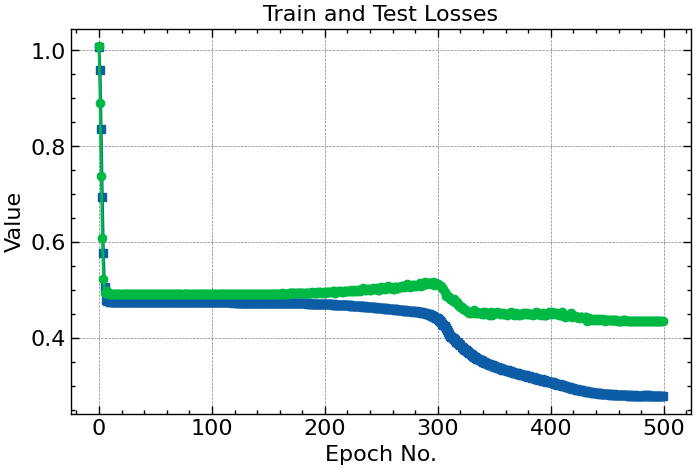

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_1_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.099605
Avg Test loss: 1.110178 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 1.055542
Avg Test loss: 0.988861 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.927786
Avg Test loss: 0.802715 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.761906
Avg Test loss

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490812 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473984
Avg Test loss: 0.490795 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473923
Avg Test loss: 0.490795 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473821
Avg Test loss: 0.490732 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473868
Avg Test loss: 0.490733 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473839
Avg Test loss: 0.490741 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473771
Avg Test loss: 0.490630 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473848
Avg Test loss: 0.490623 

Epoch 28
-------------------------------
Cur

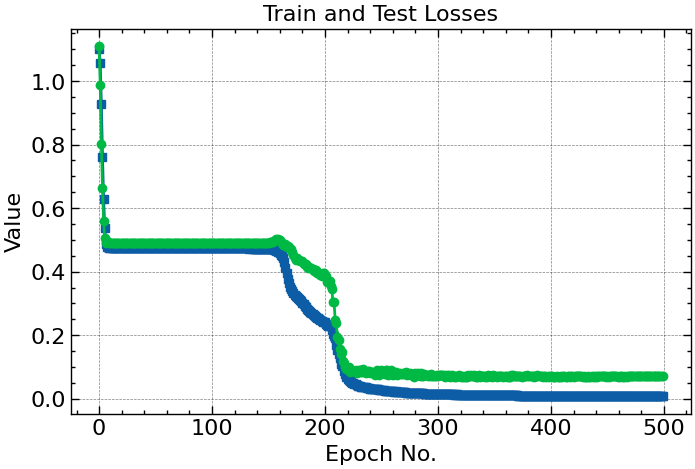

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_2_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.080636
Avg Test loss: 1.072950 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 1.035996
Avg Test loss: 0.961123 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.912084
Avg Test loss: 0.796842 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.755798
Avg Test loss

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490779 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473812
Avg Test loss: 0.490735 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473804
Avg Test loss: 0.490661 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473900
Avg Test loss: 0.490606 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473782
Avg Test loss: 0.490618 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473873
Avg Test loss: 0.490590 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473744
Avg Test loss: 0.490603 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473747
Avg Test loss: 0.490590 

Epoch 28
-------------------------------
Cur

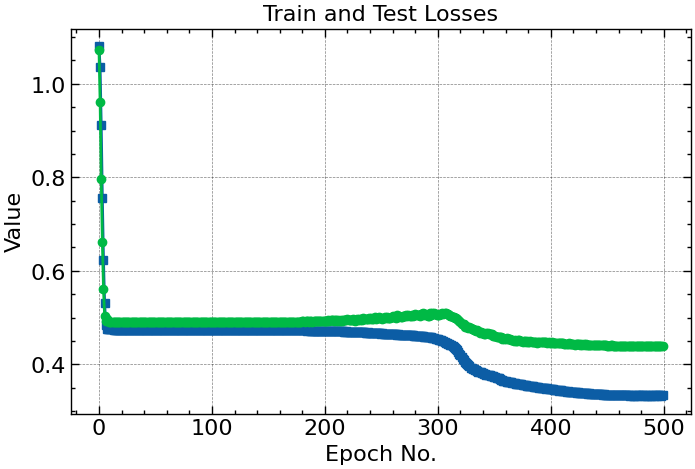

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_3_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.992288
Avg Test loss: 0.981069 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.948487
Avg Test loss: 0.867502 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.831741
Avg Test loss: 0.733186 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.706617
Avg Test loss

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.491031 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474124
Avg Test loss: 0.491008 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.474024
Avg Test loss: 0.490898 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473973
Avg Test loss: 0.490846 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473919
Avg Test loss: 0.490757 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473967
Avg Test loss: 0.490793 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473901
Avg Test loss: 0.490739 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473911
Avg Test loss: 0.490729 

Epoch 28
-------------------------------
Cur

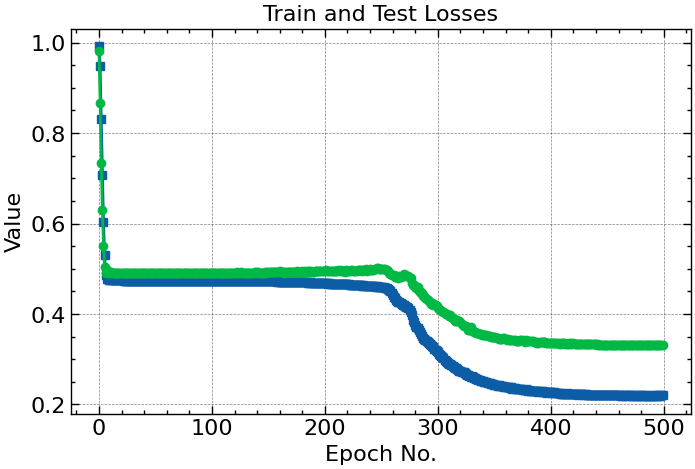

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_4_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.045906
Avg Test loss: 1.051818 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.996491
Avg Test loss: 0.919755 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.863723
Avg Test loss: 0.750852 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.709114
Avg Test loss

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490921 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474019
Avg Test loss: 0.490933 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473995
Avg Test loss: 0.490860 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473937
Avg Test loss: 0.490850 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473891
Avg Test loss: 0.490778 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473887
Avg Test loss: 0.490763 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473843
Avg Test loss: 0.490721 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473852
Avg Test loss: 0.490631 

Epoch 28
-------------------------------
Cur

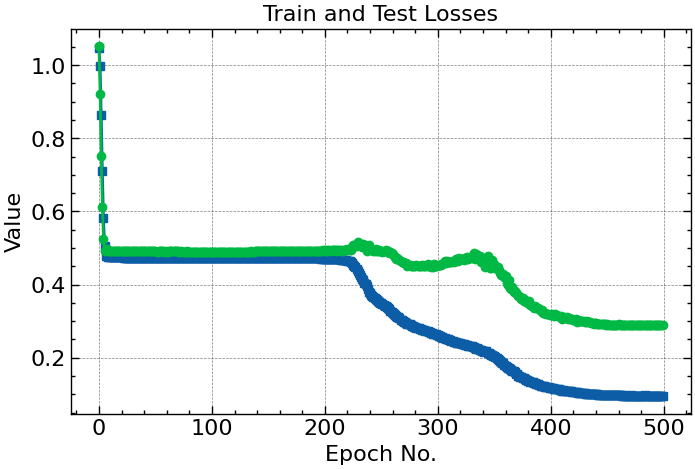

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_5_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.017558
Avg Test loss: 0.982161 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.968099
Avg Test loss: 0.858482 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.833188
Avg Test loss: 0.711805 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.683352
Avg Test loss

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490911 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474116
Avg Test loss: 0.490815 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.474005
Avg Test loss: 0.490902 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473942
Avg Test loss: 0.490775 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473902
Avg Test loss: 0.490783 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473895
Avg Test loss: 0.490759 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473871
Avg Test loss: 0.490741 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473837
Avg Test loss: 0.490694 

Epoch 28
-------------------------------
Cur

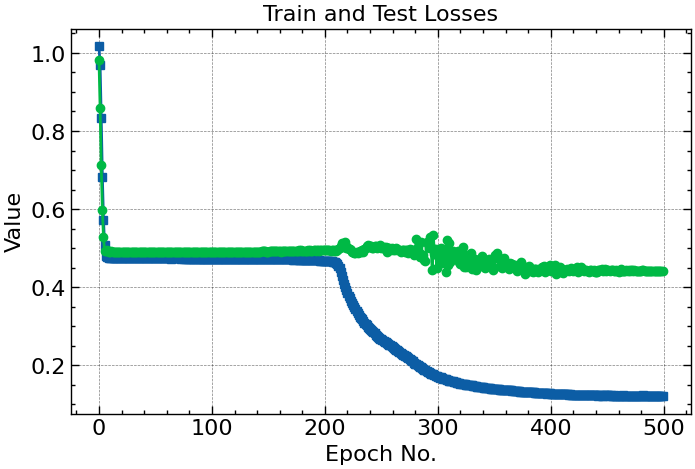

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_6_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.027691
Avg Test loss: 1.017423 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.979224
Avg Test loss: 0.891727 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.842153
Avg Test loss: 0.721223 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.684938
Avg Test loss

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.491157 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474030
Avg Test loss: 0.491148 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473916
Avg Test loss: 0.491140 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473881
Avg Test loss: 0.491097 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473772
Avg Test loss: 0.491052 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473767
Avg Test loss: 0.491030 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473766
Avg Test loss: 0.491072 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473729
Avg Test loss: 0.490970 

Epoch 28
-------------------------------
Cur

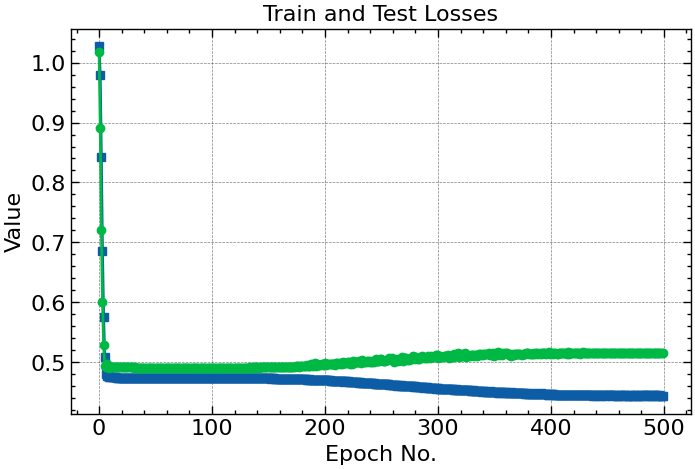

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_7_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.090161
Avg Test loss: 1.091285 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 1.048784
Avg Test loss: 0.981279 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.924357
Avg Test loss: 0.806971 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.756099
Avg Test loss

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490741 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474120
Avg Test loss: 0.490767 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.474133
Avg Test loss: 0.490720 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.474033
Avg Test loss: 0.490751 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.474014
Avg Test loss: 0.490692 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.474011
Avg Test loss: 0.490685 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473845
Avg Test loss: 0.490654 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473824
Avg Test loss: 0.490618 

Epoch 28
-------------------------------
Cur

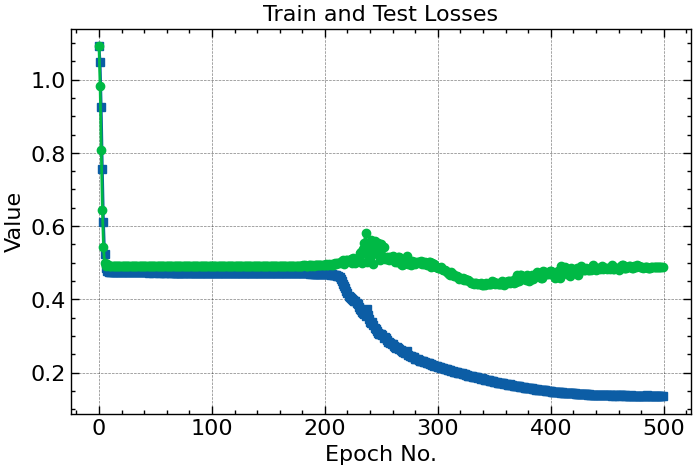

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_8_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.984550
Avg Test loss: 0.990322 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.945313
Avg Test loss: 0.884238 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.836367
Avg Test loss: 0.740429 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.703918
Avg Test loss

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490999 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474029
Avg Test loss: 0.490971 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473977
Avg Test loss: 0.490887 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473939
Avg Test loss: 0.490877 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473947
Avg Test loss: 0.490840 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473855
Avg Test loss: 0.490848 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473920
Avg Test loss: 0.490867 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473788
Avg Test loss: 0.490797 

Epoch 28
-------------------------------
Cur

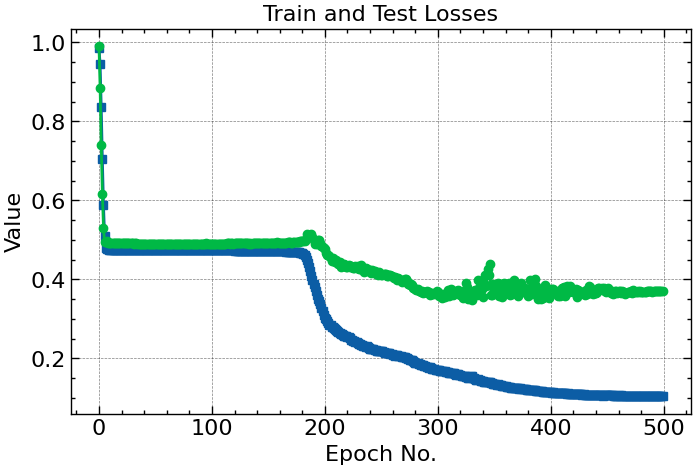

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_9_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.069252
Avg Test loss: 1.059122 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 1.024905
Avg Test loss: 0.944685 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.896371
Avg Test loss: 0.776251 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.736925
Avg Test loss

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490916 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474041
Avg Test loss: 0.490886 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473979
Avg Test loss: 0.490871 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473966
Avg Test loss: 0.490882 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473896
Avg Test loss: 0.490795 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473843
Avg Test loss: 0.490842 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473809
Avg Test loss: 0.490798 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473771
Avg Test loss: 0.490754 

Epoch 28
-------------------------------
Cur

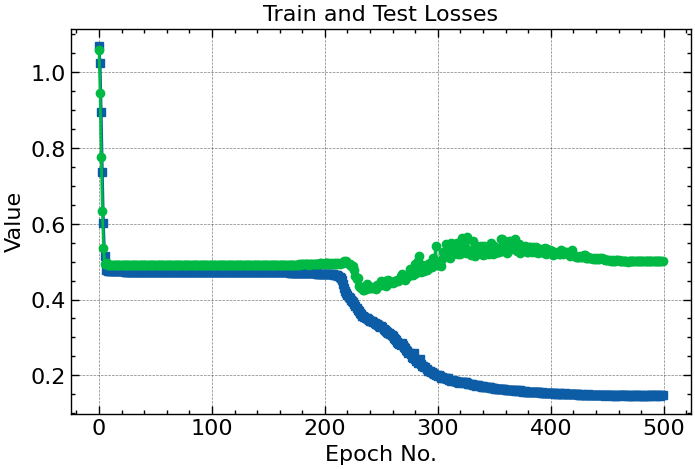

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_10_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.035751
Avg Test loss: 1.028173 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.994204
Avg Test loss: 0.921634 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.875349
Avg Test loss: 0.766875 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.721008
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490959 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474152
Avg Test loss: 0.490962 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.474099
Avg Test loss: 0.490942 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.474013
Avg Test loss: 0.490920 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473997
Avg Test loss: 0.490925 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473929
Avg Test loss: 0.490847 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473937
Avg Test loss: 0.490860 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473916
Avg Test loss: 0.490785 

Epoch 28
-------------------------------
Cur

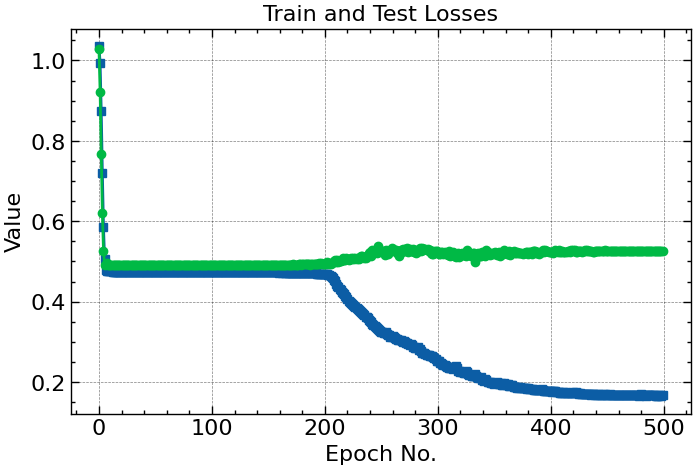

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_11_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.991517
Avg Test loss: 0.986207 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.948054
Avg Test loss: 0.876846 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.829850
Avg Test loss: 0.726958 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.690245
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490833 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473778
Avg Test loss: 0.490736 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473870
Avg Test loss: 0.490788 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473850
Avg Test loss: 0.490721 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473743
Avg Test loss: 0.490646 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473735
Avg Test loss: 0.490670 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473788
Avg Test loss: 0.490571 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473688
Avg Test loss: 0.490583 

Epoch 28
-------------------------------
Cur

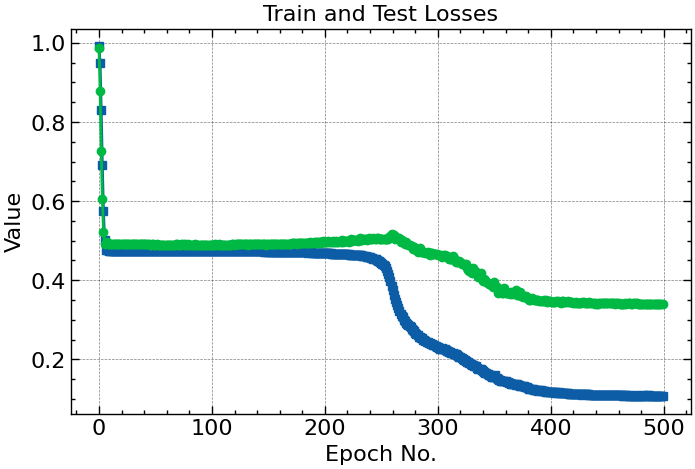

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_12_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.041447
Avg Test loss: 1.044298 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.988326
Avg Test loss: 0.894975 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.845576
Avg Test loss: 0.727176 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.693073
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490962 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473943
Avg Test loss: 0.490968 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473864
Avg Test loss: 0.490943 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473921
Avg Test loss: 0.490966 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473838
Avg Test loss: 0.490858 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473855
Avg Test loss: 0.490864 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473856
Avg Test loss: 0.490821 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473827
Avg Test loss: 0.490857 

Epoch 28
-------------------------------
Cur

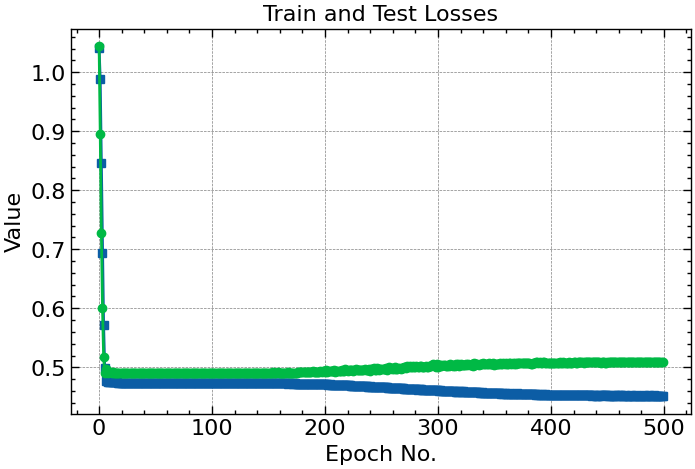

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_13_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.969265
Avg Test loss: 0.966515 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.925333
Avg Test loss: 0.855219 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.808076
Avg Test loss: 0.702143 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.668697
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.491100 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474046
Avg Test loss: 0.490999 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473966
Avg Test loss: 0.491000 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473891
Avg Test loss: 0.490956 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473944
Avg Test loss: 0.490915 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473821
Avg Test loss: 0.490830 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473877
Avg Test loss: 0.490887 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473682
Avg Test loss: 0.490838 

Epoch 28
-------------------------------
Cur

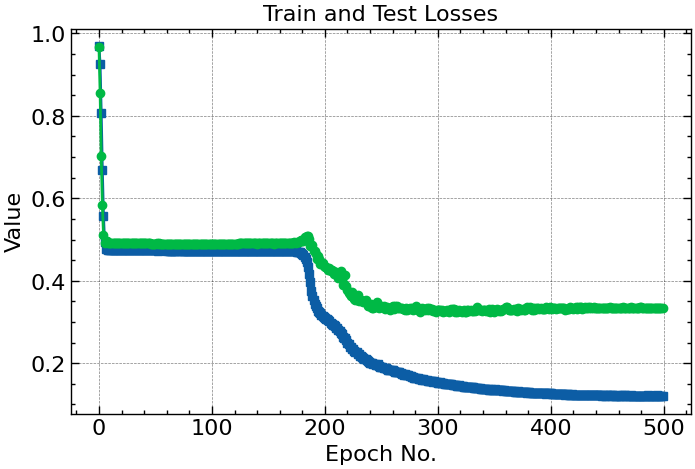

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_14_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.010896
Avg Test loss: 0.994073 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.959238
Avg Test loss: 0.857133 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.814197
Avg Test loss: 0.681186 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.653078
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.491290 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474039
Avg Test loss: 0.491184 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.474060
Avg Test loss: 0.491183 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473900
Avg Test loss: 0.491090 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473951
Avg Test loss: 0.491114 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473809
Avg Test loss: 0.491054 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473859
Avg Test loss: 0.491027 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473826
Avg Test loss: 0.490972 

Epoch 28
-------------------------------
Cur

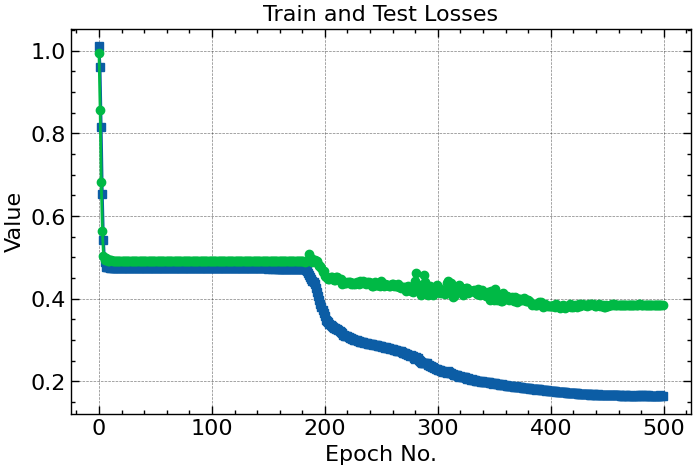

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_15_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.926970
Avg Test loss: 0.918141 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.884511
Avg Test loss: 0.809260 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.770950
Avg Test loss: 0.671960 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.643460
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490832 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474118
Avg Test loss: 0.490867 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.474072
Avg Test loss: 0.490853 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.474046
Avg Test loss: 0.490821 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473883
Avg Test loss: 0.490824 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473919
Avg Test loss: 0.490751 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473910
Avg Test loss: 0.490740 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473800
Avg Test loss: 0.490669 

Epoch 28
-------------------------------
Cur

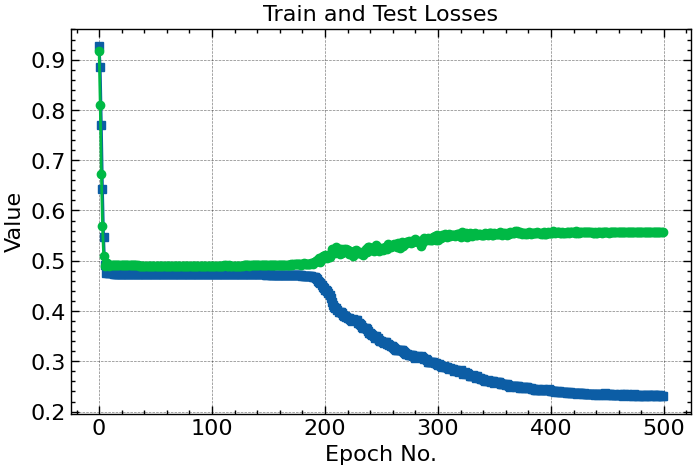

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_16_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.019541
Avg Test loss: 1.013709 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.970897
Avg Test loss: 0.883253 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.843644
Avg Test loss: 0.732186 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.704745
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490492 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474134
Avg Test loss: 0.490509 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.474042
Avg Test loss: 0.490522 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473969
Avg Test loss: 0.490519 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473976
Avg Test loss: 0.490504 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473949
Avg Test loss: 0.490527 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473806
Avg Test loss: 0.490530 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473791
Avg Test loss: 0.490526 

Epoch 28
-------------------------------
Cur

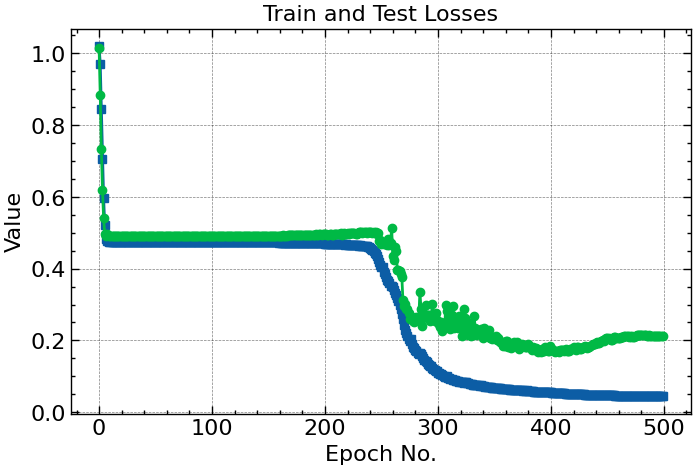

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_17_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.012698
Avg Test loss: 1.023256 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.961179
Avg Test loss: 0.887736 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.817261
Avg Test loss: 0.696744 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.658085
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490736 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474119
Avg Test loss: 0.490740 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473993
Avg Test loss: 0.490669 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473944
Avg Test loss: 0.490660 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473968
Avg Test loss: 0.490646 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473841
Avg Test loss: 0.490624 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473888
Avg Test loss: 0.490604 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473818
Avg Test loss: 0.490580 

Epoch 28
-------------------------------
Cur

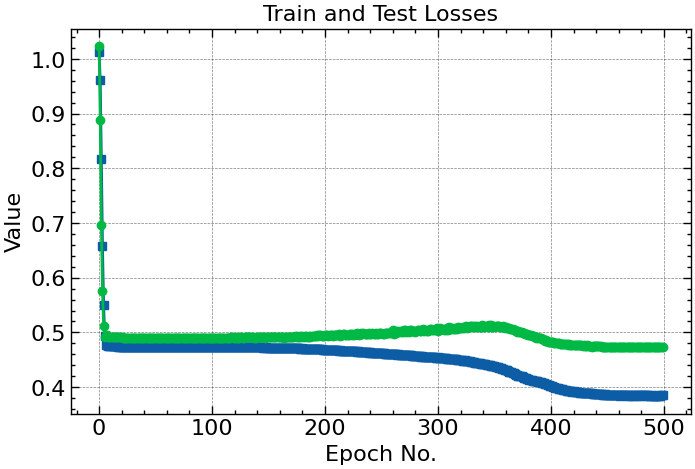

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_18_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.006919
Avg Test loss: 0.998648 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.962989
Avg Test loss: 0.888659 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.843911
Avg Test loss: 0.744453 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.704494
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490790 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474041
Avg Test loss: 0.490740 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473997
Avg Test loss: 0.490682 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473906
Avg Test loss: 0.490660 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473888
Avg Test loss: 0.490639 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473796
Avg Test loss: 0.490559 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473768
Avg Test loss: 0.490527 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473819
Avg Test loss: 0.490501 

Epoch 28
-------------------------------
Cur

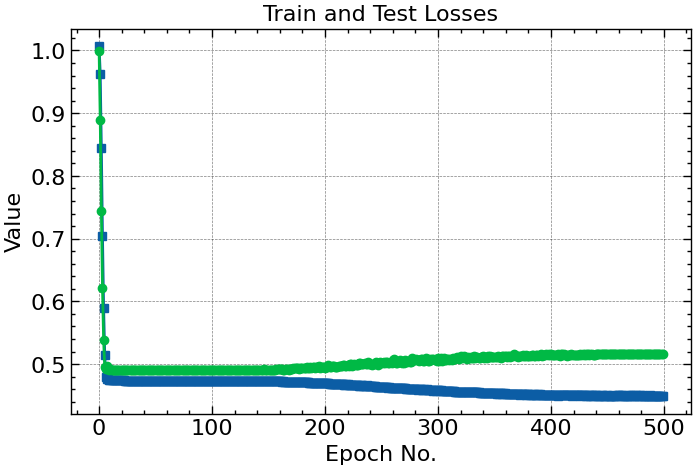

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_19_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.068118
Avg Test loss: 1.096409 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 1.017585
Avg Test loss: 0.955731 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.879195
Avg Test loss: 0.771921 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.725758
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490918 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474037
Avg Test loss: 0.490840 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473926
Avg Test loss: 0.490820 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473917
Avg Test loss: 0.490744 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473865
Avg Test loss: 0.490727 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473820
Avg Test loss: 0.490660 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473778
Avg Test loss: 0.490652 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473737
Avg Test loss: 0.490682 

Epoch 28
-------------------------------
Cur

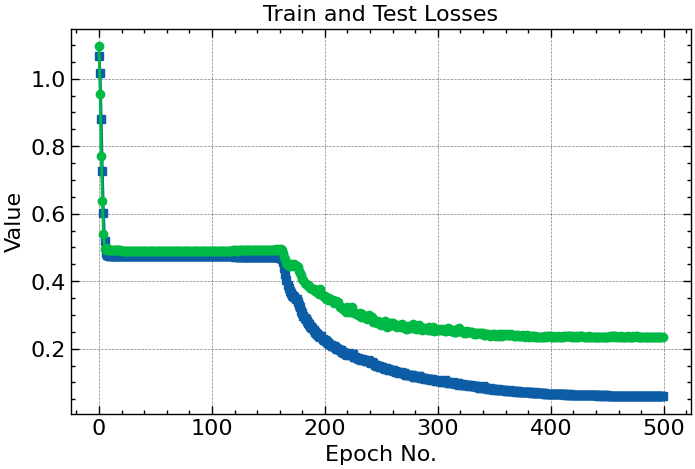

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_20_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.057068
Avg Test loss: 1.058570 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 1.009399
Avg Test loss: 0.929001 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.867743
Avg Test loss: 0.733803 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.694230
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490981 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474004
Avg Test loss: 0.490979 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473870
Avg Test loss: 0.490877 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473850
Avg Test loss: 0.490830 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473827
Avg Test loss: 0.490832 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473736
Avg Test loss: 0.490798 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473778
Avg Test loss: 0.490776 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473744
Avg Test loss: 0.490753 

Epoch 28
-------------------------------
Cur

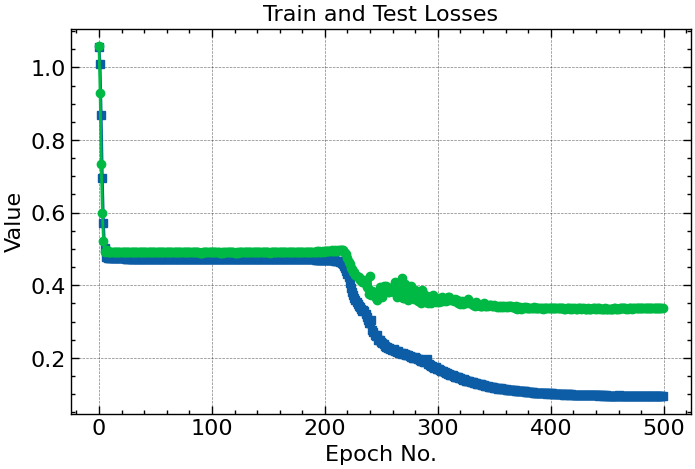

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_21_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.957173
Avg Test loss: 0.953377 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.908453
Avg Test loss: 0.823378 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.772601
Avg Test loss: 0.661807 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.628898
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490740 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473993
Avg Test loss: 0.490677 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473955
Avg Test loss: 0.490656 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473934
Avg Test loss: 0.490623 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473879
Avg Test loss: 0.490624 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473879
Avg Test loss: 0.490570 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473839
Avg Test loss: 0.490531 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473762
Avg Test loss: 0.490490 

Epoch 28
-------------------------------
Cur

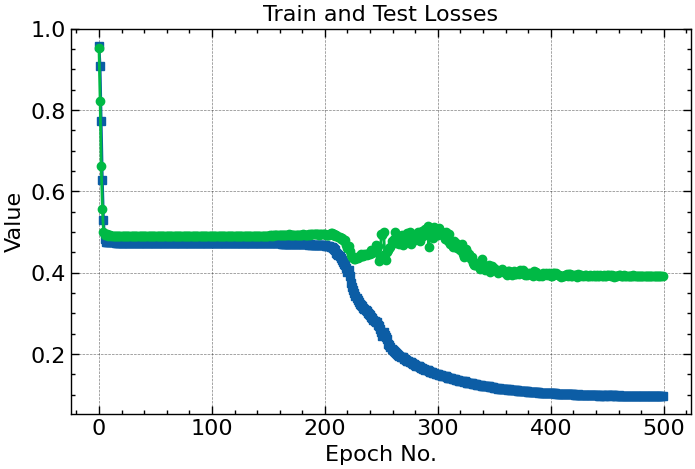

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_22_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.027441
Avg Test loss: 1.043627 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.977755
Avg Test loss: 0.910059 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.843752
Avg Test loss: 0.734334 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.696844
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490659 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473955
Avg Test loss: 0.490710 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473897
Avg Test loss: 0.490619 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473948
Avg Test loss: 0.490607 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473823
Avg Test loss: 0.490544 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473835
Avg Test loss: 0.490577 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473807
Avg Test loss: 0.490520 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473768
Avg Test loss: 0.490513 

Epoch 28
-------------------------------
Cur

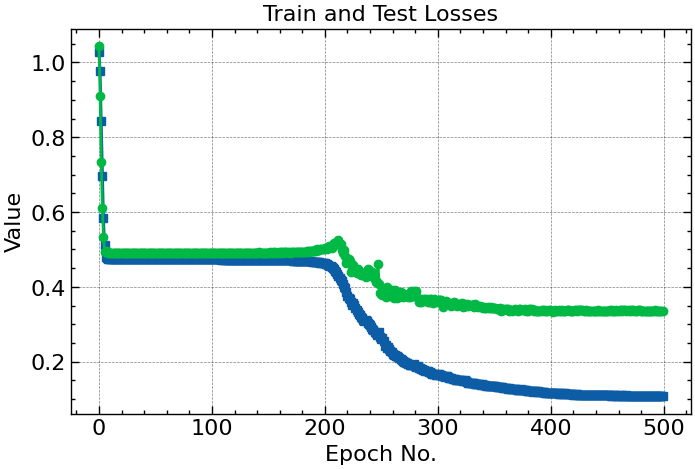

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_23_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.019688
Avg Test loss: 1.018739 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.963596
Avg Test loss: 0.869837 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.813763
Avg Test loss: 0.687647 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.659898
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490930 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474059
Avg Test loss: 0.490912 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.474026
Avg Test loss: 0.490850 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.474025
Avg Test loss: 0.490868 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473982
Avg Test loss: 0.490829 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473945
Avg Test loss: 0.490753 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473868
Avg Test loss: 0.490754 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473861
Avg Test loss: 0.490718 

Epoch 28
-------------------------------
Cur

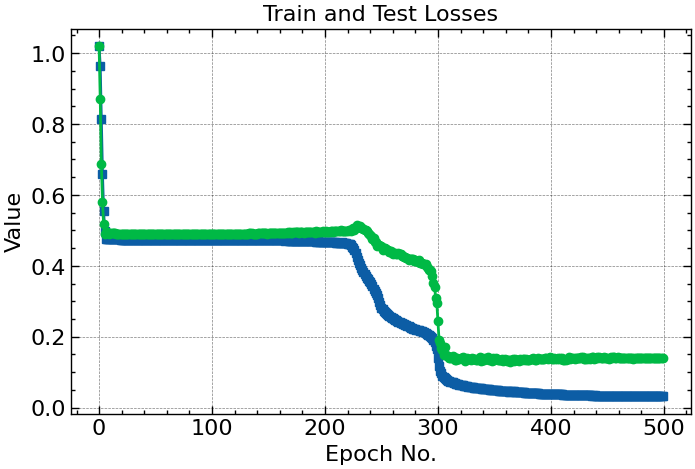

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_24_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.998001
Avg Test loss: 1.008878 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.952911
Avg Test loss: 0.888073 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.835233
Avg Test loss: 0.748659 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.706566
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.491093 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473980
Avg Test loss: 0.491045 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473903
Avg Test loss: 0.491020 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473865
Avg Test loss: 0.490927 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473875
Avg Test loss: 0.490943 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473847
Avg Test loss: 0.490904 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473745
Avg Test loss: 0.490913 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473822
Avg Test loss: 0.490957 

Epoch 28
-------------------------------
Cur

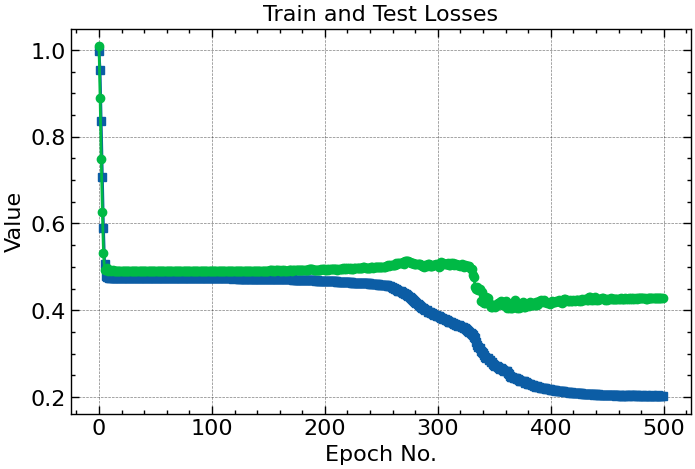

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_25_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.033343
Avg Test loss: 1.041924 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.995442
Avg Test loss: 0.936587 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.882589
Avg Test loss: 0.776586 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.735389
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490765 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473908
Avg Test loss: 0.490732 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473932
Avg Test loss: 0.490659 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473867
Avg Test loss: 0.490684 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473875
Avg Test loss: 0.490587 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473807
Avg Test loss: 0.490577 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473769
Avg Test loss: 0.490540 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473737
Avg Test loss: 0.490519 

Epoch 28
-------------------------------
Cur

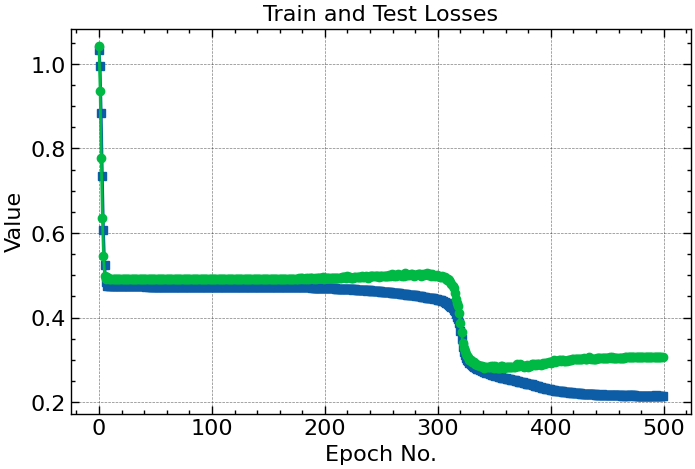

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_26_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.029232
Avg Test loss: 1.040298 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.987659
Avg Test loss: 0.921752 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.876992
Avg Test loss: 0.785390 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.743518
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490635 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473899
Avg Test loss: 0.490562 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473917
Avg Test loss: 0.490589 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473823
Avg Test loss: 0.490558 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473856
Avg Test loss: 0.490528 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473779
Avg Test loss: 0.490477 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473740
Avg Test loss: 0.490534 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473673
Avg Test loss: 0.490491 

Epoch 28
-------------------------------
Cur

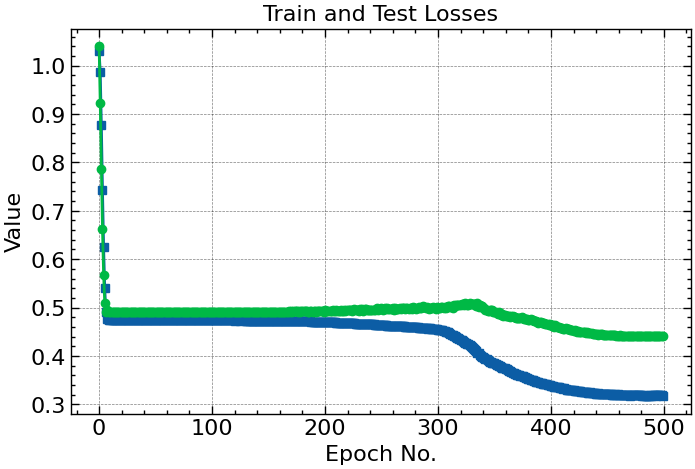

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_27_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.915145
Avg Test loss: 0.910788 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.874812
Avg Test loss: 0.806295 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.770079
Avg Test loss: 0.681718 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.651233
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490821 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474030
Avg Test loss: 0.490814 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473942
Avg Test loss: 0.490782 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473905
Avg Test loss: 0.490794 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473905
Avg Test loss: 0.490768 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473817
Avg Test loss: 0.490752 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473793
Avg Test loss: 0.490804 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473695
Avg Test loss: 0.490825 

Epoch 28
-------------------------------
Cur

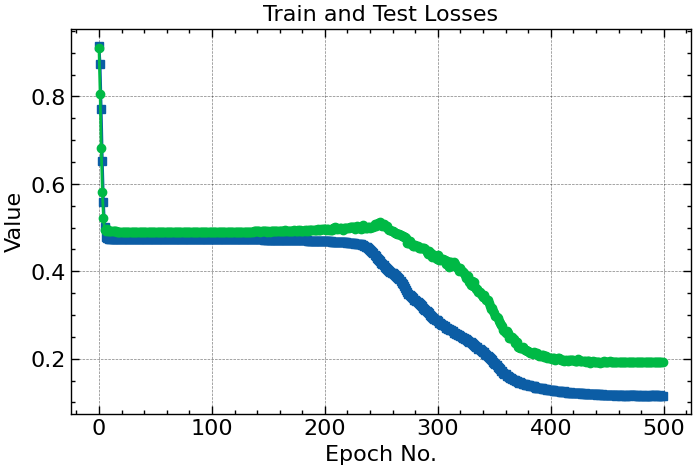

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_28_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.019172
Avg Test loss: 1.038036 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.973201
Avg Test loss: 0.908641 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.853716
Avg Test loss: 0.761605 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.725043
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.491273 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474088
Avg Test loss: 0.491147 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473980
Avg Test loss: 0.491141 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473915
Avg Test loss: 0.491102 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473874
Avg Test loss: 0.491031 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473919
Avg Test loss: 0.491020 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473897
Avg Test loss: 0.491043 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473761
Avg Test loss: 0.491005 

Epoch 28
-------------------------------
Cur

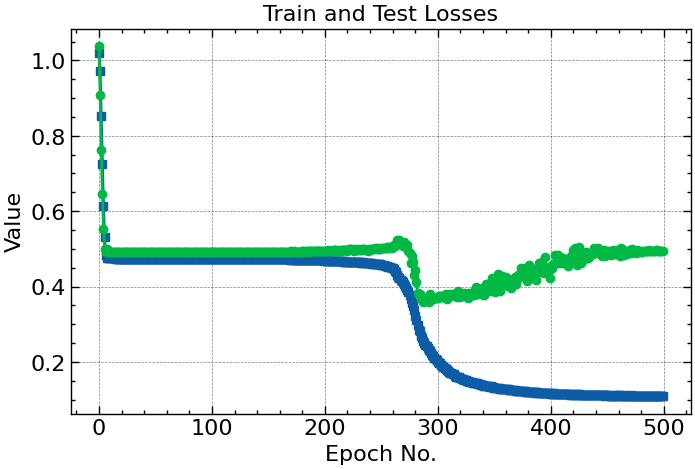

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_29_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.992040
Avg Test loss: 0.992722 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.946326
Avg Test loss: 0.867417 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.823459
Avg Test loss: 0.716225 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.680708
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490659 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473993
Avg Test loss: 0.490717 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.474001
Avg Test loss: 0.490674 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473983
Avg Test loss: 0.490697 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473828
Avg Test loss: 0.490667 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473832
Avg Test loss: 0.490650 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473769
Avg Test loss: 0.490653 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473784
Avg Test loss: 0.490642 

Epoch 28
-------------------------------
Cur

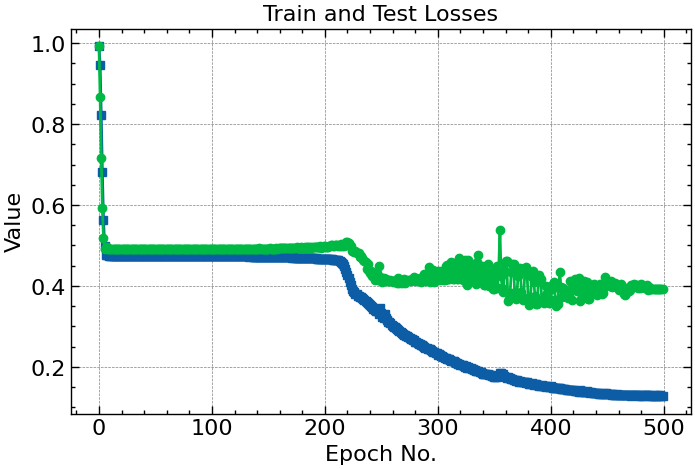

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_30_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.960331
Avg Test loss: 0.940587 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.909802
Avg Test loss: 0.815504 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.787834
Avg Test loss: 0.688715 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.663562
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490840 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474165
Avg Test loss: 0.490678 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.474059
Avg Test loss: 0.490721 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473925
Avg Test loss: 0.490743 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473906
Avg Test loss: 0.490676 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473881
Avg Test loss: 0.490655 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473814
Avg Test loss: 0.490673 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473860
Avg Test loss: 0.490637 

Epoch 28
-------------------------------
Cur

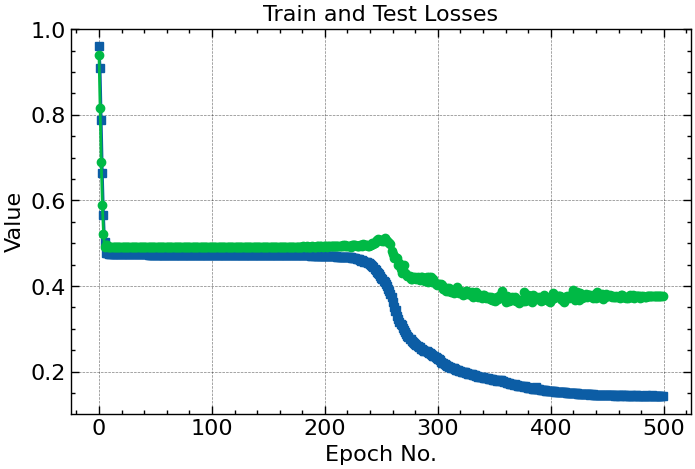

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_31_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.013022
Avg Test loss: 1.015340 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.959581
Avg Test loss: 0.861843 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.815081
Avg Test loss: 0.693785 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.660517
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.491111 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474033
Avg Test loss: 0.490931 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.474022
Avg Test loss: 0.490919 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473949
Avg Test loss: 0.490833 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473861
Avg Test loss: 0.490814 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473806
Avg Test loss: 0.490859 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473789
Avg Test loss: 0.490821 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473723
Avg Test loss: 0.490756 

Epoch 28
-------------------------------
Cur

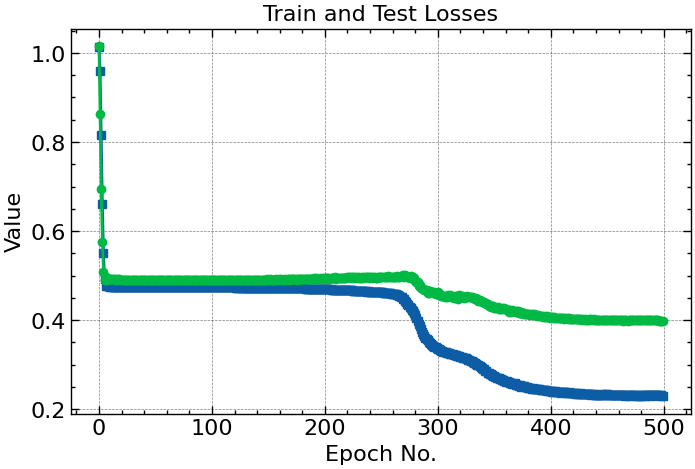

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/96_test_index_32_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.969359
Avg Test loss: 0.961850 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.926104
Avg Test loss: 0.855095 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.810979
Avg Test loss: 0.716834 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.680214
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490823 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474099
Avg Test loss: 0.490755 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.474002
Avg Test loss: 0.490675 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473941
Avg Test loss: 0.490639 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473898
Avg Test loss: 0.490651 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473846
Avg Test loss: 0.490561 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473822
Avg Test loss: 0.490563 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473739
Avg Test loss: 0.490539 

Epoch 28
-------------------------------
Cur

KeyboardInterrupt: 

In [7]:
for i in range(100):
    training_script(96, index=i)

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/32_test_index_0_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.122885
Avg Test loss: 1.137645 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 1.070450
Avg Test loss: 0.989405 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.924345
Avg Test loss: 0.804117 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.756180
Avg Test loss

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.491048 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473995
Avg Test loss: 0.491030 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473996
Avg Test loss: 0.491002 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473897
Avg Test loss: 0.490922 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473780
Avg Test loss: 0.490902 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473772
Avg Test loss: 0.490917 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473804
Avg Test loss: 0.490891 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473806
Avg Test loss: 0.490786 

Epoch 28
-------------------------------
Cur

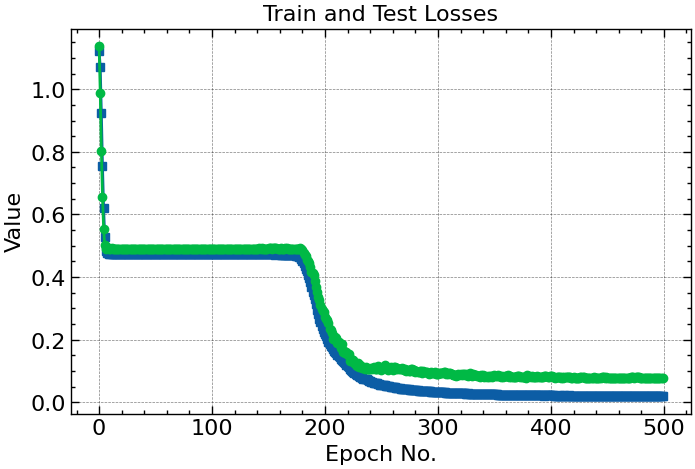

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/64_test_index_0_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.092045
Avg Test loss: 1.108201 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 1.035707
Avg Test loss: 0.961470 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.887691
Avg Test loss: 0.773824 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.723637
Avg Test loss

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490890 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474011
Avg Test loss: 0.490767 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473956
Avg Test loss: 0.490698 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473844
Avg Test loss: 0.490680 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473870
Avg Test loss: 0.490626 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473787
Avg Test loss: 0.490611 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473803
Avg Test loss: 0.490549 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473789
Avg Test loss: 0.490579 

Epoch 28
-------------------------------
Cur

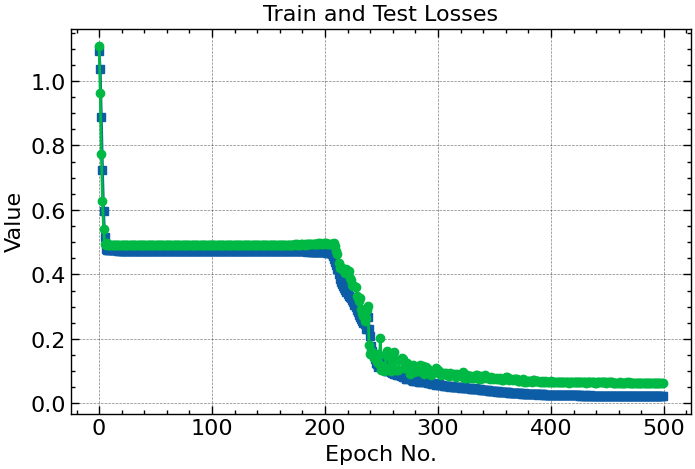

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/128_test_index_0_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.961506
Avg Test loss: 0.949678 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.914411
Avg Test loss: 0.825193 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.788357
Avg Test loss: 0.675327 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.648318
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490823 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474136
Avg Test loss: 0.490808 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473929
Avg Test loss: 0.490742 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473973
Avg Test loss: 0.490681 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473945
Avg Test loss: 0.490705 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473884
Avg Test loss: 0.490609 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473936
Avg Test loss: 0.490575 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473796
Avg Test loss: 0.490563 

Epoch 28
-------------------------------
Cur

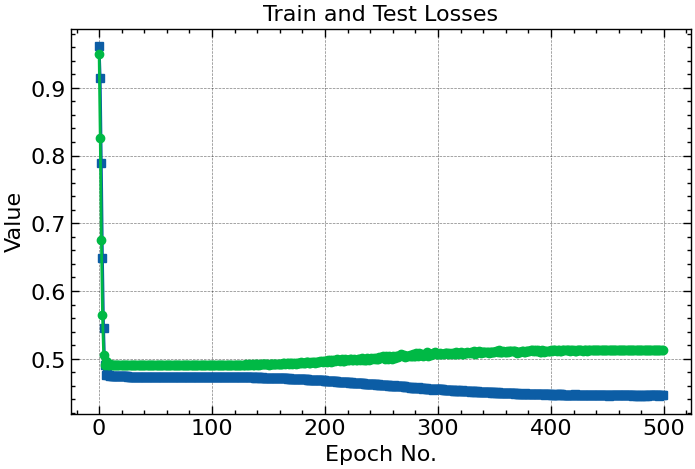

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/256_test_index_0_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.988848
Avg Test loss: 0.983229 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.945429
Avg Test loss: 0.867940 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.823949
Avg Test loss: 0.719089 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.682468
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490821 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473967
Avg Test loss: 0.490811 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473855
Avg Test loss: 0.490731 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473883
Avg Test loss: 0.490722 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473830
Avg Test loss: 0.490725 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473740
Avg Test loss: 0.490688 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473765
Avg Test loss: 0.490683 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473702
Avg Test loss: 0.490656 

Epoch 28
-------------------------------
Cur

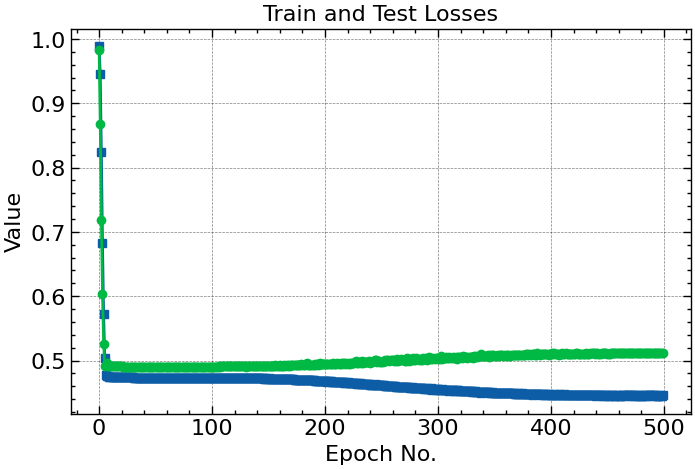

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/512_test_index_0_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.023047
Avg Test loss: 1.044586 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.964659
Avg Test loss: 0.890043 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.815082
Avg Test loss: 0.702109 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.655485
Avg Test los

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.491042 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.473993
Avg Test loss: 0.491045 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473864
Avg Test loss: 0.490982 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473949
Avg Test loss: 0.490947 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473747
Avg Test loss: 0.490982 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473801
Avg Test loss: 0.490926 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473826
Avg Test loss: 0.490934 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473749
Avg Test loss: 0.490911 

Epoch 28
-------------------------------
Cur

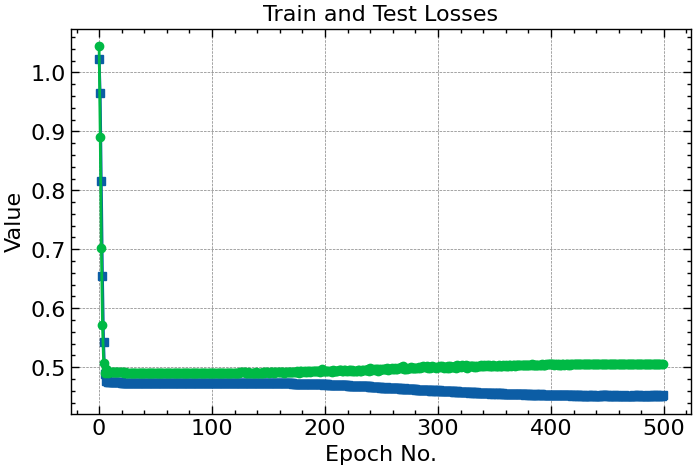

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/1024_test_index_0_fixed_combined' created successfully.

Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Using device: cuda

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 1.070715
Avg Test loss: 1.085164 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 1.018193
Avg Test loss: 0.943369 

Epoch 3
-------------------------------
Current Learning Rate: 0.000150085
Train loss: 0.872020
Avg Test loss: 0.752159 

Epoch 4
-------------------------------
Current Learning Rate: 0.00020008
Train loss: 0.714318
Avg Test lo

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.490919 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999892908320648
Train loss: 0.474033
Avg Test loss: 0.490853 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999571637870036
Train loss: 0.473966
Avg Test loss: 0.490825 

Epoch 23
-------------------------------
Current Learning Rate: 0.0009999036202410325
Train loss: 0.473869
Avg Test loss: 0.490785 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009998286624877787
Train loss: 0.473909
Avg Test loss: 0.490780 

Epoch 25
-------------------------------
Current Learning Rate: 0.000999732293738183
Train loss: 0.473876
Avg Test loss: 0.490773 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009996145181203617
Train loss: 0.473816
Avg Test loss: 0.490783 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009994753406794303
Train loss: 0.473793
Avg Test loss: 0.490745 

Epoch 28
-------------------------------
Cur

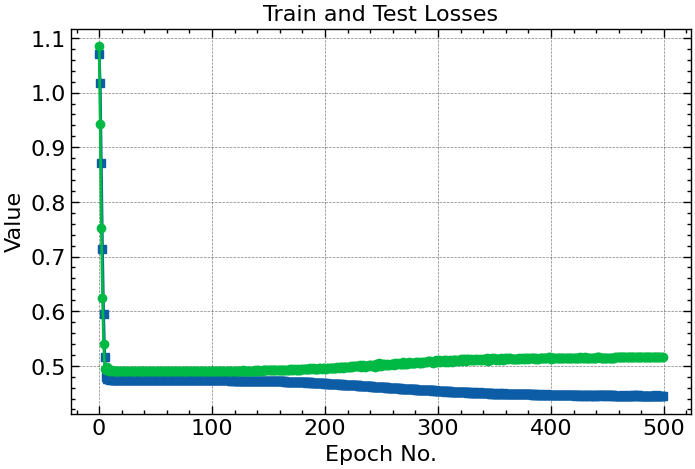

In [25]:
for num_freqs in [32, 64, 128, 256, 512, 1024]:
    training_script(num_freqs)

Using device: cuda

Folder '/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/64_test_index_0_fixed_combined' already exists.

Loading model from /blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/64_test_index_0_fixed_combined/hubbard_model_2BPV_HF_model_num_freqs_64_final_fixed_combined.pth
Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817
Training dataset length: 548

Training dataset length: 1029

Test dataset length: 28

Epoch 1
-------------------------------
Current Learning Rate: 5.0094999999999994e-05
Train loss: 0.023110
Avg Test loss: 0.064317 

Saving model...
Model saved!

Epoch 2
-------------------------------
Current Learning Rate: 0.00010008999999999999
Train loss: 0.023327
Avg Test loss: 0.064297 

Ep

/blue/yujiabin/awwab.azam/hartree-fock-code/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Avg Test loss: 0.058601 

Epoch 21
-------------------------------
Current Learning Rate: 0.0009999999005096281
Train loss: 0.034396
Avg Test loss: 0.073324 

Epoch 22
-------------------------------
Current Learning Rate: 0.0009999996020385524
Train loss: 0.027349
Avg Test loss: 0.059124 

Epoch 23
-------------------------------
Current Learning Rate: 0.000999999104586891
Train loss: 0.033718
Avg Test loss: 0.055731 

Epoch 24
-------------------------------
Current Learning Rate: 0.0009999984081548422
Train loss: 0.027458
Avg Test loss: 0.062159 

Epoch 25
-------------------------------
Current Learning Rate: 0.0009999975127426832
Train loss: 0.026282
Avg Test loss: 0.066457 

Epoch 26
-------------------------------
Current Learning Rate: 0.0009999964183507704
Train loss: 0.024541
Avg Test loss: 0.064811 

Epoch 27
-------------------------------
Current Learning Rate: 0.0009999951249795391
Train loss: 0.022868
Avg Test loss: 0.053322 

Epoch 28
-------------------------------
Cur

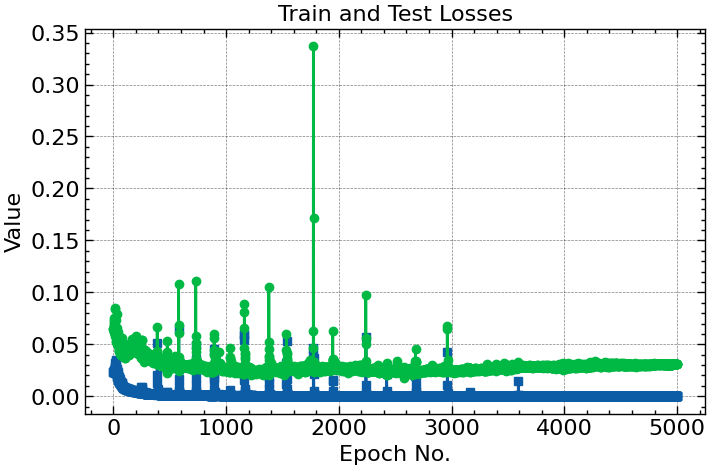

In [35]:
training_script(64)

### Inference / Evaluation

In [3]:
def plot_complex_matrix(
    matrix,
    title="OP matrix",
    interpolation="none",
    vmin=-1.0,
    vmax=1.0,
    log_scale=False,
):
    """
    Plots a matrix. If the matrix is complex, plots both the real and imaginary parts.
    If the matrix is real, plots only the real part.

    Args:
        matrix (np.ndarray): Matrix to plot.
        log_scale (bool): Whether to use log scale for color mapping. Default is False.
    """
    if not isinstance(matrix, np.ndarray):
        raise TypeError("Input must be a NumPy array.")

    def get_plot_data(data):
        if log_scale:
            # Add a small epsilon to avoid log(0)
            epsilon = 1e-12
            return np.log10(np.abs(data) + epsilon)
        else:
            return data

    if np.iscomplexobj(matrix):
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        im0 = axs[0].imshow(
            get_plot_data(matrix.real),
            cmap="RdBu",
            interpolation=interpolation,
            vmin=vmin,
            vmax=vmax,
        )
        plt.colorbar(im0, ax=axs[0])
        axs[0].set_title(f"Re of {title}" + (" (log scale)" if log_scale else ""))

        im1 = axs[1].imshow(
            get_plot_data(matrix.imag),
            cmap="BrBG",
            interpolation=interpolation,
            vmin=vmin,
            vmax=vmax,
        )
        plt.colorbar(im1, ax=axs[1])
        axs[1].set_title(f"Im of {title}" + (" (log scale)" if log_scale else ""))

        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 8))
        plt.imshow(
            get_plot_data(matrix),
            cmap="RdBu",
            interpolation=interpolation,
            vmin=vmin,
            vmax=vmax,
        )
        plt.colorbar()
        plt.title(f"Re of {title}" + (" (log scale)" if log_scale else ""))
        plt.tight_layout()
        plt.show()

In [4]:
def reformat_diagonal(diagonal_matrix, relation):
    # diagonal_matrix should be of shape (L, L, 2, 2)
    L = diagonal_matrix.shape[0]
    folded_OP_mat = np.zeros((L**2, L**2, 2, 2))

    # loop over the diagonal matrix
    for v_1_L in range(L):
        for v_2_L in range(L):
            v_1 = v_1_L / L
            v_2 = v_2_L / L
            v_1_prime = relation(v_1)
            v_2_prime = relation(v_2)

            v_1_prime_L = int(round(v_1_prime * L))
            v_2_prime_L = int(round(v_2_prime * L))

            # get row and column indices
            row_idx = (v_1_L * L) + v_2_L
            col_idx = (v_1_prime_L * L) + v_2_prime_L

            # fill in the folded OP matrix
            folded_OP_mat[row_idx, col_idx, :, :] = diagonal_matrix[v_1_L, v_2_L, :, :]

    return folded_OP_mat


def reformat_matrix_from_diagonals(diagonal_matrices):
    folded_OP_mat = reformat_diagonal(diagonal_matrices[0], relation=lambda v: v)
    folded_OP_mat += reformat_diagonal(
        diagonal_matrices[1], relation=lambda v: (v + 0.5) % 1
    )
    return folded_OP_mat

In [5]:
def fold_OP_mat(OP_mat):
    # input should be of shape (2L^2, 2L^2)
    L = int(round(math.sqrt(OP_mat.shape[0] / 2)))
    print(f"L is {L}")

    # fold the alpha's (2x2 matrices)
    folded_OP = np.zeros((L**2, L**2, 2, 2))
    real_part = OP_mat.real

    for k_1 in range(L):
        for k_2 in range(L):
            for k_1_prime in range(L):
                for k_2_prime in range(L):
                    row_idx = (2 * k_1 * L) + (2 * k_2)
                    col_idx = (2 * k_1_prime * L) + (2 * k_2_prime)
                    alpha_matrix = real_part[
                        row_idx : row_idx + 2, col_idx : col_idx + 2
                    ]
                    i = k_1 * L + k_2
                    j = k_1_prime * L + k_2_prime
                    folded_OP[i, j, :, :] = alpha_matrix

    # return the result
    return folded_OP

In [6]:
def unfold_OP_mat(folded_OP_mat):
    # input of shape (L^2, L^2, 2, 2)
    L = int(round(math.sqrt(folded_OP_mat.shape[0])))
    print(f"L is {L}")

    OP_mat = np.zeros((2 * (L**2), 2 * (L**2)), dtype=np.complex128)

    for k_1 in range(L):
        for k_2 in range(L):
            for k_1_prime in range(L):
                for k_2_prime in range(L):
                    alpha_matrix = folded_OP_mat[
                        k_1 * L + k_2, k_1_prime * L + k_2_prime, :, :
                    ]
                    for i in range(2):
                        for j in range(2):
                            alpha_1 = i
                            alpha_2 = j
                            row_idx = (2 * k_1 * L) + (2 * k_2) + alpha_1
                            col_idx = (2 * k_1_prime * L) + (2 * k_2_prime) + alpha_2
                            OP_mat[row_idx, col_idx] = alpha_matrix[i, j] + (1j * 0)

    # return the result
    return OP_mat

In [17]:
def main_function(num_freqs, dim, indices, test_index=0, epoch=None):
    NUM_FREQS = num_freqs

    # directory for model + normalization constants
    folder_name = "hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11"
    directory = f"/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/{folder_name}/"

    # Check if CUDA is available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    num_samples = indices[1] - indices[0]

    # get the filenames
    dims = [dim]
    filenames = [f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/diagonal_coords_{d}x{d}.pt" for d in dims]

    # load model (make sure matches what's in the folder)
    model = utils.HF_SimpleModel(
        filenames,
        num_layers = 3,
        input_dim = 8,
        embed_dim = 64,
        output_dim = 8,
        num_heads = 4,
        num_freqs = NUM_FREQS,
        dim_feedforward = 128,
        input_dropout = 0.1,
        output_dropout = 0.0,
        dropout = 0.1,
        device = device
    )

    # Load the saved state_dict
    if epoch is None:
        model_filename = f"{directory}{NUM_FREQS}_test_index_{test_index}_fixed_combined/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_final_fixed_combined.pth"
    else:
        model_filename = f"{directory}{NUM_FREQS}_test_index_{test_index}_fixed_combined/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_epoch_{epoch}_fixed_combined.pth"

    print(f"Loading model from {model_filename}")
    state_dict = torch.load(model_filename)

    # Create a new state_dict without the prefix
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('_orig_mod.'):
            name = k[10:] # remove `_orig_mod.`
            new_state_dict[name] = v
        else:
            new_state_dict[k] = v

    # Load the corrected state_dict
    model.load_state_dict(new_state_dict)


    # get number of trainable parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {num_params}")

    # load normalization constants from file
    with open(directory + f"normalization_constants_combined.json", "r") as f:
        normalization_constants = json.load(f)

    x_mean = normalization_constants["x_mean"]
    x_std = normalization_constants["x_std"]
    y_mean = normalization_constants["y_mean"]
    y_std = normalization_constants["y_std"]

    print("Normalization Constants:")
    print(f"\nInputs Mean: {x_mean}, Inputs Standard Deviation: {x_std}")
    print(f"Targets Mean: {y_mean}, Targets Standard Deviation: {y_std}")

    # load dataset
    eval_dataset = utils.HF_3x3_Dataset(f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/U_1_ground_state/hubbard_model_lowest_energy_{dim}x{dim}_U_1_ground_state.h5", normalization_constants, indices=indices)
    print(f"\nDataset size: {eval_dataset.__len__()}")

    # make a new DataLoader for testing purposes
    eval_dataloader = DataLoader(
        eval_dataset, batch_size=50, shuffle=True, pin_memory=True, num_workers=2
    )

    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    num_batches = len(eval_dataloader)
    test_loss = 0
    loss_fn = torch.nn.MSELoss()
    results_list = []


    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in eval_dataloader:
            # Move data to the appropriate device (CPU/GPU)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # convert to correct format
            pred = utils.denormalize(pred, y_mean, y_std)
            pred = pred.cpu().numpy()
            results_list.append(pred)
    
    results_list = np.concatenate(results_list, axis=0)
    # results_list should now be of shape (num_samples, L^2, 8)

    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")
    
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/output/L_{dim}_old_NN_diagonal_decomposition_num_freqs_{NUM_FREQS}_fixed_combined_1.h5", "w") as f:
        for i in range(num_samples):
            folded_OP_mat = reformat_matrix_from_diagonals((
                results_list[i, :, :4].reshape((dim, dim, 2, 2)),
                results_list[i, :, 4:].reshape((dim, dim, 2, 2))
            ))
            OP_mat = unfold_OP_mat(folded_OP_mat)
            # enforce Hermiticity
            OP_mat = (OP_mat + OP_mat.conj().T) / 2
            
            OP_mat = np.transpose(OP_mat)
            OP_mat = np.array([OP_mat.real, OP_mat.imag])
            f.create_dataset(f"ML_{i+1}", data=OP_mat)

    return results_list

In [42]:
# generate outputs
# main_function(num_freqs=96, dim=8, indices=(0, 100), test_index=1)
# main_function(num_freqs=96, dim=10, indices=(0, 100), test_index=1)
# main_function(num_freqs=96, dim=12, indices=(0, 31), test_index=1)
# main_function(num_freqs=96, dim=14, indices=(0, 23), test_index=1)
# main_function(num_freqs=96, dim=16, indices=(0, 22), test_index=1)
main_function(num_freqs=64, dim=18, indices=(0, 28), test_index=0, epoch=4001)

Using device: cuda


Loading model from /blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/64_test_index_0_fixed_combined/hubbard_model_2BPV_HF_model_num_freqs_64_epoch_4001_fixed_combined.pth
Number of trainable parameters: 103264
Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817

Dataset size: 28
Test loss: 0.029620 

L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18
L is 18


array([[[-4.25553322e-03,  3.36766243e-06, -5.31971455e-06, ...,
          3.39746475e-06, -1.04308128e-07,  5.80840111e-02],
        [-3.01109254e-03,  3.67313623e-06, -5.00679016e-06, ...,
          3.76254320e-06,  1.49011612e-07,  6.47874698e-02],
        [-3.33100557e-03,  3.41236591e-06, -5.27501106e-06, ...,
          3.39746475e-06, -1.04308128e-07,  6.31817058e-02],
        ...,
        [ 8.67272913e-03,  3.94880772e-07, -5.52833080e-06, ...,
          2.82377005e-06, -3.27825546e-07,  1.16728514e-01],
        [ 1.11922994e-02, -2.45869160e-07, -5.73694706e-06, ...,
          2.28732824e-06, -5.81145287e-07,  1.22686066e-01],
        [ 4.71701473e-03,  1.12503767e-06, -5.55813313e-06, ...,
          2.75671482e-06, -3.72529030e-07,  9.88265201e-02]],

       [[-3.11504304e-03,  3.44216824e-06, -5.21540642e-06, ...,
          3.43471766e-06,  7.45058060e-08,  6.36541992e-02],
        [-4.85022366e-03,  3.68803740e-06, -5.21540642e-06, ...,
          3.62098217e-06,  8.19563866e

In [19]:
main_function(num_freqs=64, dim=30, indices=(0, 48), test_index=0, epoch=4001)

Using device: cuda
Loading model from /blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/hubbard_model_trans_breaking_old_NN_diagonal_decomposition_aug11/64_test_index_0_fixed_combined/hubbard_model_2BPV_HF_model_num_freqs_64_epoch_4001_fixed_combined.pth
Number of trainable parameters: 103264
Normalization Constants:

Inputs Mean: 0.9988349080085754, Inputs Standard Deviation: 0.4569081962108612
Targets Mean: 0.12499968707561493, Targets Standard Deviation: 0.3307192027568817

Dataset size: 48
Test loss: 0.081460 

L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30
L is 30


array([[[-5.2044690e-03,  4.3883920e-06, -4.8130751e-06, ...,
          4.0382147e-06,  3.3527613e-07,  5.5547096e-02],
        [-4.4978410e-03,  4.3883920e-06, -4.6938658e-06, ...,
          4.1723251e-06,  4.2468309e-07,  6.0557000e-02],
        [ 1.4290959e-03,  3.8743019e-06, -4.6640635e-06, ...,
          3.8966537e-06,  4.5448542e-07,  7.8136012e-02],
        ...,
        [ 1.3098508e-02,  2.3096800e-07, -5.5134296e-06, ...,
          2.5928020e-06, -4.6193600e-07,  1.2523463e-01],
        [ 6.1052516e-03,  1.6018748e-06, -5.3048134e-06, ...,
          3.0472875e-06, -2.1606684e-07,  1.0141604e-01],
        [ 1.4707357e-02, -3.5762787e-07, -5.6624413e-06, ...,
          2.2053719e-06, -6.5565109e-07,  1.3021477e-01]],

       [[-3.9300621e-03,  4.9993396e-06, -4.4554472e-06, ...,
          4.5299530e-06,  6.1839819e-07,  5.6187689e-02],
        [-4.6511739e-03,  4.9844384e-06, -4.5746565e-06, ...,
          4.3585896e-06,  4.8428774e-07,  5.3645015e-02],
        [-2.9633045e-03, 

L is 30


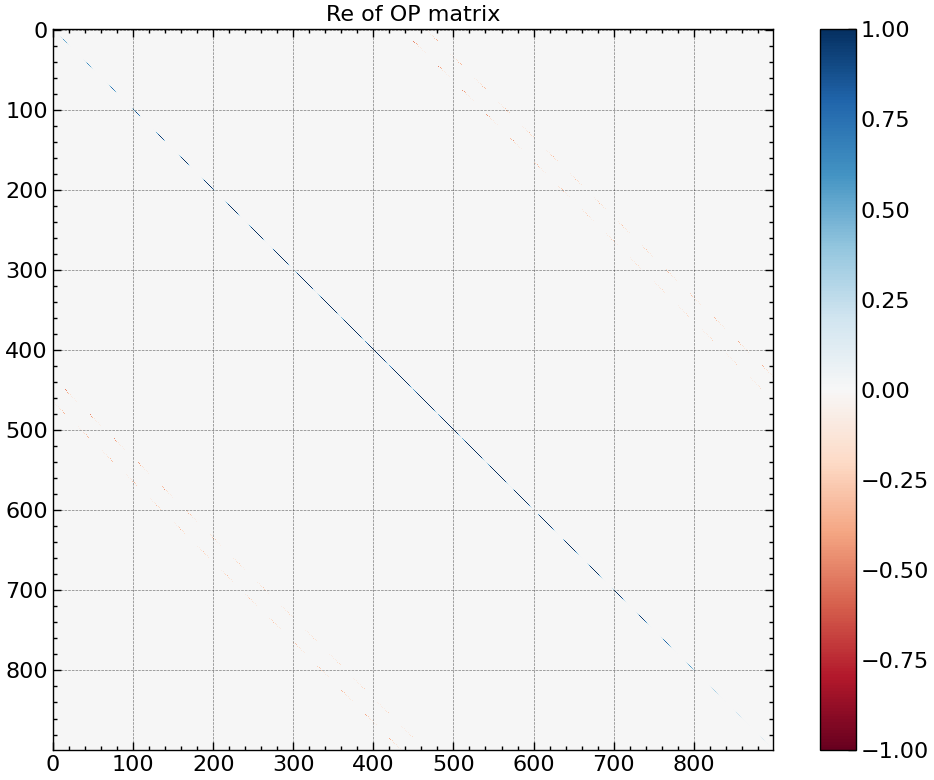

In [21]:
# check outputs
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/output/L_30_old_NN_diagonal_decomposition_num_freqs_64_fixed_combined_1.h5", 'r') as f:
    OP_mat = np.transpose(f['ML_1'][()])
    OP_mat = OP_mat[:, :, 0] + (1j * OP_mat[:, :, 1])
    plot_complex_matrix(fold_OP_mat(OP_mat)[:, :, 0, 0])

In [ ]:
def get_test_loss(num_freqs):
    NUM_FREQS = num_freqs

    # get norm constants dict
    with open("normalization_constants.json", "r") as f: 
        normalization_constants = json.load(f)

    VAL_DATASET = "/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/tMoTe2_model/tMoTe2_dataset_18x18_10K.h5"
    validation_data = utils.HF_3x3_Dataset(VAL_DATASET, normalization_constants, indices=(0, 5_000))
    print(f"Test dataset length: {validation_data.__len__()}\n")
    val_dataloader = DataLoader(validation_data, BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)

    # Check if CUDA is available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # get the filenames
    dims = list(range(3, 19, 3))    # should go from 3 to 18 in increments of 3
    # filenames = [f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/tMoTe2_model/BZindex_{d}x{d}.pt" for d in dims]
    filenames = [f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/tMoTe2_model/true_momentum_{d}x{d}.pt" for d in dims]

    # load model (make sure matches what's in the folder)
    model = utils.HF_SimpleModel(
        filenames,
        num_layers = 3,
        input_dim = 32,
        embed_dim = 64,
        output_dim = 32,
        num_heads = 4,
        num_freqs = NUM_FREQS,
        dim_feedforward = 128,
        input_dropout = 0.0,
        output_dropout = 0.0,
        dropout = 0.0,
        device = device
    )

    # Load the saved state_dict
    state_dict = torch.load(f"/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/tMoTe2_6x6_9x9_freq_test_lc_july5/tMoTe2_2BPV_HF_model_num_freqs_{NUM_FREQS}.pth")

    # Create a new state_dict without the prefix
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('_orig_mod.'):
            name = k[10:] # remove `_orig_mod.`
            new_state_dict[name] = v
        else:
            new_state_dict[k] = v

    # Load the corrected state_dict
    model.load_state_dict(new_state_dict)

    validation_loss = utils.test_loop([val_dataloader], model, torch.nn.MSELoss(reduction = "sum"), device)

    print(f"Test loss for {NUM_FREQS} frequencies is: {validation_loss}")

vals = [256, 512, 1024]
for val in vals:
    get_test_loss(val)

Test dataset length: 5000

Using device: cuda



Avg Test loss: 0.496273 

Test loss for 256 frequencies is: 0.49627314211998474
Test dataset length: 5000

Using device: cuda

Avg Test loss: 0.496270 

Test loss for 512 frequencies is: 0.4962695270302856
Test dataset length: 5000

Using device: cuda

Avg Test loss: 0.496264 

Test loss for 1024 frequencies is: 0.4962641866801697
